# Programowanie matematyczne / Optymalizacja

Optymalizacja (lub ogólniej programowanie matematyczne gdy nie ma funkcji kosztu/jakości) polega na znalezieniu wartości dla zmiennych, na przykład zmiennej dla której funkcja przyjmuje minimalną wartość, wag sieci neuronowej aby zmaksymalizować detekcję obiektów, prędkości początkowej kuli przy wystrzale z armaty w celu trafienia do celu czy sterowania robotem w celu pokonania jakiejś trasy. W wielu przypadkach, wartości zmiennych nie mogą przyjmować dowolnej wartości, np. gdy zmienną decyzyjną jest odległość (a więc jest większa/równa zeru). Stąd, definiujemy różne ograniczenia, które muszą być spełnione aby zaakceptować rozwiązanie problemu.

Przykładowo, poniżej zdefiniowany jest problem minimalizacji funkcji kwadratowej przy ograniczeniu, że x musi być większe od 0.5:
$min_x f(x)=x^2, x >= 0.5$.

Jest to przykład programowania kwadratowego, jednej z najczęściej używanych podkategorii programowania matematycznego gdzie funkcja kosztu jest kwadratowa a ograniczenia są liniowe. Ten sam problem, możemy zdefiniować i rozwiązać korzystając z biblioteki *Drake*.

In [1]:
import numpy as np

from pydrake.all import MathematicalProgram, IpoptSolver, ge, le, eq
from pydrake.symbolic import ToLatex
from IPython.display import display, Latex

prog = MathematicalProgram() # Instance of mathematical program
x = prog.NewContinuousVariables(1, 'x') # 1 element vector of decision variables named x
prog.AddQuadraticCost(x @ x) # Matrix product (since x is 1 element vector also known as 1 x 1 matrix)
prog.AddLinearConstraint(ge(x, 0.5 * np.ones_like(x))) # x >= 0.5 constraint

solver = IpoptSolver() # Internal-point method solver, default solver from Solve function is SNOPT which has more restricted licence
result = solver.Solve(prog) # Solve the mathematical program instance
assert result.is_success()

print(result.GetSolution(x))

[0.5]


Jak widać powyżej, problem został rozwiązany poprawnie, solver znalazł minimalna wartość $x$, która spełnia wszystkie ograniczenia. Programowanie kwadratowe ma ogromną zaletę, mianowicie, o ile istnieje, rozwiązanie zostanie znalezione. Jeżeli żadna wartość zmiennych decyzyjnych nie spełnia ograniczeń, solver zwróci informację, że problem jest nie do spełnienia. W ogólności, program matematyczny może nie zostać rozwiązany, nawet jak rozwiązanie istnieje (metody są zwykle lokalne, oparte np. o gradienty).

Bardziej zbliżonym do sterowania problemem może być ustalenie prędkości wystrzału pocisku z armaty do celu: http://www.matthewpeterkelly.com/tutorials/trajectoryOptimization/canon.html. Najpierw rozpatrzymy wersję bez oporu powietrza i rozwiązanie analityczne zamiast symulacji. Następnie przejdziemy do pełnej wersji korzystając z wiedzy z poprzedniego ćwiczenia odnośnie równań dynamiki w przestrzeni stanu.
![Picture title](image-20230123-112147.png).

Załóżmy, że wystrzał kuli ma miejsce w punkcie

$q_{0}=(0, 0)$,

natomiast cel jest ustawiony w odległości 3 metrów na wysokości 1 metra:

$q_{T}=(3, 1)$

po 0.1 sekundy po wystrzale. Znająć położenie oraz prędkść początkową $q_0, \dot{q_0}$ możemy ustalić położenie końcowe w chwili $t$ jako

$q(t) = q_0 + t \dot{q_0} + t^2 \ddot{q} / 2$

gdzie $\ddot{q}=(0, -g)=(0, -9.81)$ Zmienną decyzyjną w zadaniu jest prędkość początkowa $\dot{q_0}$. Tak więc program matematyczny do rozwiązani jest jak poniżej:

Find $\dot{q_0}$
s.t. $q_T=(3, 1)$

Jak widać, nie jest to zadanie optymalizacji, gdyż nie mamy funkcji kosztu/jakości. Powyższy program można rozwiązać korzystając z biblioteki *Drake*, co zrobiono poniżej 

In [2]:
prog = MathematicalProgram() # Instantiate new mathematical program
q_0 = np.float32([0, 0]) # Initial position q = (x, y)
q_0_dot = prog.NewContinuousVariables(2, '\dot{q_0}') # Decision variable for initial velocity q_dot = (x_dot, y_dot)
q_T = np.float32([3, 1]) # Final position q = (x, y)
t = 0.1 # Time of flight
g = 9.81 # Gravity
q_dot_dot = np.float32([0, -g]) # Gravity in full coordinates

# Physics constraint derived from equation of motion: m * q_dot_dot = m * g
# integrated two times with q_0 and q_dot_0 initial conditions
prog.AddConstraint(eq(q_0 + t * q_0_dot + t ** 2 * q_dot_dot / 2, q_T))

solver = IpoptSolver()
result = solver.Solve(prog)
assert result.is_success()
print(result.GetSolution(q_0_dot))

[30.     10.4905]


Powyżej założyliśmy czas lotu $t=0.1$ s. Nic nie stoi na przeszkodzie, żeby uznać czas lotu za zmienną decyzyjną i znaleźć $\dot{q_0}$ dla którego czas lotu będzie najkrótszy a kula trafi do celu.

In [3]:
prog = MathematicalProgram()

q_0_dot = prog.NewContinuousVariables(2, '\dot{q_0}')
t = prog.NewContinuousVariables(1, 't') # Time of flight as decision variable on which we put the cost function J = t^2

# Initial guess for time of flight - in nonlinear case, the optimization is very sensitive to initial guess.
# In general, one can use motion capture of some performed trajectory, linear/polynomial interpolation between initial/goal state etc.
prog.SetInitialGuess(t, np.float32([1.0]))

q_0 = np.float32([0, 0])
q_T = np.float32([3, 1])
g = 9.81
q_dot_dot = np.float32([0, -g])
prog.AddConstraint(eq(q_0 + t * q_0_dot + t ** 2 * q_dot_dot / 2, q_T))

prog.AddQuadraticCost(t @ t) # Cost on time of flight. The shorter the better
# Note that optimal cost value (0) for t=0 violates equation of motiion constraint that (added just above).
# The optimizer tries it best to find the smallest t that still satisfies the constraints.
# Formulated like this, initial velocity can be arbitraly high and either local minima will be encountered
# or iterations limit for optimization. One can add more constraints (e.x. limit speed v = sqrt(x_dot^2 + y_dot^2)
# or add cost on speed.

solver = IpoptSolver()
result = solver.Solve(prog)
assert result.is_success()
print(f"q_dot_0 = {result.GetSolution(q_0_dot)}")
print(f"t_optimal = {result.GetSolution(t)}")

q_dot_0 = [28566.57880476  9522.19345003]
t_optimal = [0.00010502]


# Pełna wersja problemu - kolokacja trapezoidalna

Poniżej zaimplementujemy pełną wersję problemu, opisaną na podlinkowanym tutorialu. Wykorzystamy kolokację trapezoidalną, gdzie trajektoria jest reprezentowana jako odcinkowo-liniowa funkcja (patrz pkt. 3 w https://epubs.siam.org/doi/epdf/10.1137/16M1062569 oraz fig.3 tamże). Zadania do realizacji:

1. Uzupełnij funkcje *canon_dynamics(state, c, g)* określającą dynamikę lecącej kuli z oporem powietrza
2. Dodaj ograniczenie na pozycję początkową (0, 0) i końcową (3, 1)
3. Rozwiąż program matematyczny bez oporu powietrza (c=0) - canon_dynamics_no_drag
4. Rozwiąż program matematyczny z oporem powietrza (c=0.4) - canon_dynamics_with_drag
    a) Czy solver znalazł rozwiązanie?
5. Jak wspomniano wyżej, w przypadku programowania nieliniowego, wartość poczatkowa zmiennych ma istotny wpływ na jakość rozwiązania. Ustaw trajektorię początkową na rozwiązanie z optymalizacji bez oporu powietrza. Czy udało się uzyskać rozwiązanie?
6. Zamiast podwójnego rozwiązywania problemu, spróbuj ustawić prędkość początkową. Czy w ten sposób udalo się znaleźć rozwiązanie?

A. Uzupełnij pola z komentarzem TODO:
B. Odpowiedzi na pytania umieść w nowej komórce markdown (3 poziome linie na prawo od komórki -> add new markdown cell below)

### ODPOWIEDZI

#### Czy solver znalazł rozwiązanie?
Tak, dla obu przypadków solver znalazł rozwiązania, zarówno z oporem powietrza, jak i bez niego.

#### Jak wspomniano wyżej, w przypadku programowania nieliniowego, wartość poczatkowa zmiennych ma istotny wpływ na jakość rozwiązania. Ustaw trajektorię początkową na rozwiązanie z optymalizacji bez oporu powietrza. Czy udało się uzyskać rozwiązanie?
Zgodnie z zaleceniem, ustawienie trajektorii początkowej na wynik optymalizacji bez oporu powietrza umożliwiło solverowi szybsze osiągnięcie zbieżności, co poprawiło jakość rozwiązania.

#### Zamiast podwójnego rozwiązywania problemu, spróbuj ustawić prędkość początkową. Czy w ten sposób udalo się znaleźć rozwiązanie?
Tak, również przy ustawieniu prędkości początkowej solver zdołał znaleźć rozwiązanie, co pozwoliło ominąć podwójne rozwiązywanie problemu i uprościło optymalizację

In [4]:
from functools import partial
from pydrake.all import sqrt, Solve


def canon_dynamics(state, c, g):
    # State consist of position, q=(x, y), and velocity, q_dot=(x_dot, y_dot)
    x, y, x_dot, y_dot = state

    v_sqr = x_dot * x_dot + y_dot * y_dot
    v = v_sqr ** 0.5
    x_dot_dot = -c * (x_dot * v)
    y_dot_dot = -c * (y_dot * v) - g
    state_dot = np.array([x_dot, y_dot, x_dot_dot, y_dot_dot])
    return state_dot

def initialize_state_trajectory(N):
    # Initialize 
    traj_initial = np.zeros((N, 4), dtype=np.float32)
    traj_initial[:, 0] = np.linspace(0, 3, N)
    traj_initial[:, 1] = np.linspace(0, 1, N)
    traj_initial[:-1, 2] = traj_initial[1:, 0] - traj_initial[:-1, 0]
    traj_initial[:-1, 3] = traj_initial[1:, 1] - traj_initial[:-1, 1]
    return traj_initial

c_no_drag = 0.0
c_drag = 0.4
g = 9.81
canon_dynamics_no_drag = partial(canon_dynamics, c=c_no_drag, g=g)
canon_dynamics_with_drag = partial(canon_dynamics, c=c_drag, g=g)

In [5]:
# Test to check the dynamics function
state_test = np.ones(4)
c_test = 0.7
state_test_dot = np.array([1., 1., -0.98994949, -10.79994949])
np.testing.assert_allclose(canon_dynamics(state_test, c_test, g), state_test_dot)

In [6]:
def solve_optimization(dynamics=canon_dynamics_no_drag, traj_initial=None, N=50):
    prog = MathematicalProgram()

    N = N
    t = prog.NewContinuousVariables(1, 't')
    prog.AddConstraint(ge(t, np.array([0.01])))
    prog.SetInitialGuess(t, np.float32([1.0]))

    h = t / N

    traj = prog.NewContinuousVariables(N, 4, 'traj') # x, y, x_dot, y_dot trajectory
    if traj_initial is None:
        traj_initial = initialize_state_trajectory(N)
    else:
        traj_initial=traj_initial
    prog.SetInitialGuess(traj, traj_initial)

    prog.AddConstraint(eq(traj[0, :2], np.array([0, 0])))
    prog.AddConstraint(eq(traj[-1, :2], np.array([3, 1])))


    traj_dot = np.array([dynamics(traj[i]) for i in range(N)])
    
    for i in range(N - 1):
        state_dot = dynamics(traj[i])  
        prog.AddConstraint(eq(traj[i + 1], traj[i] + h * state_dot))


    prog.AddCost(traj[0, 2]**2 + traj[0, 3]**2)  # Minimizes squared speed


    solver = IpoptSolver()
    result = solver.Solve(prog)
    assert result.is_success()
    return result.GetSolution(traj), result.GetSolution(t)

## Rozwiązanie bez oporu powietrza

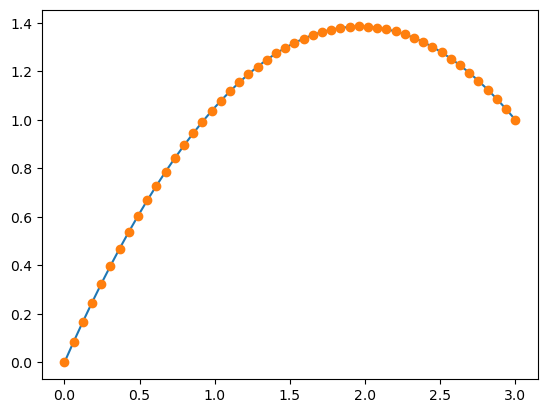

In [7]:
from matplotlib import pyplot as plt

traj_sol, t_sol = solve_optimization(dynamics=canon_dynamics_no_drag)
xy = traj_sol[:, :2]
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(xy[:, 0], xy[:, 1], 'o');

Z racji braku oporu powietrza, prędkość na osi $x$ nie powinna się zmieniać, co widać po równym odstępie punktów kontrolnych na osi x (pomarańczowe koła). Poniższy wykres tylko to potwierdza. 

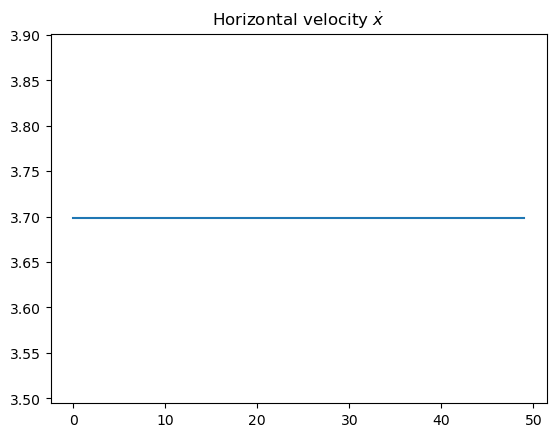

In [8]:
plt.plot(traj_sol[:, 2])
plt.title('Horizontal velocity $\dot{x}$');

## Rozwiązanie z oporem powietrza

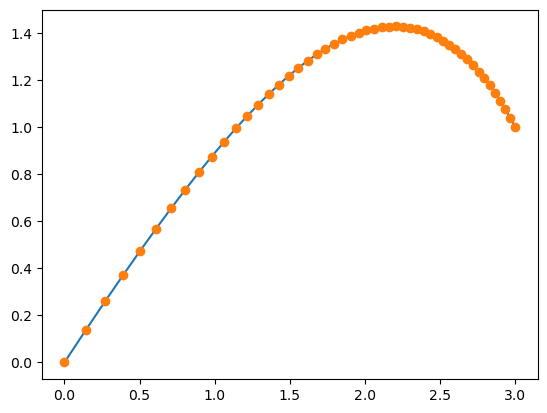

In [9]:
traj_sol, t_sol = solve_optimization(dynamics=canon_dynamics_with_drag, traj_initial=traj_sol)
xy = traj_sol[:, :2]
plt.plot(xy[:, 0], xy[:, 1])
plt.plot(xy[:, 0], xy[:, 1], 'o');

W przypadku oporu powietrza, prędkość na osi $x$ zmniejsza się, stąd większe zagęszczenie punktów kontrolnych w dalszej części lotu. Jak wyżej, zilustrujemy to wykreślając prędkość na osi $x$.

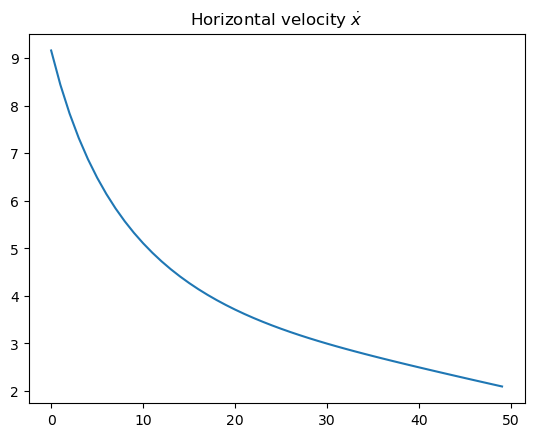

In [10]:
plt.plot(traj_sol[:, 2])
plt.title('Horizontal velocity $\dot{x}$');

## Ustawienie prędkości początkowej

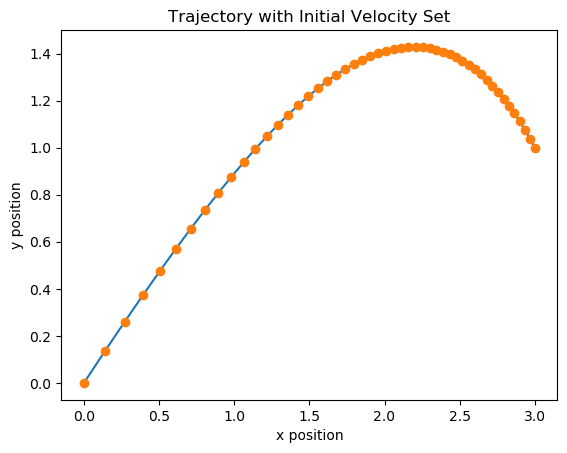

In [11]:

traj_initial = initialize_state_trajectory(50)

initial_x_dot = 10.0  
initial_y_dot = 15.0  

traj_initial[0, 2] = initial_x_dot
traj_initial[0, 3] = initial_y_dot

traj_sol, t_sol = solve_optimization(dynamics=canon_dynamics_with_drag, traj_initial=traj_initial, N=50)

xy = traj_sol[:, :2]

plt.plot(xy[:, 0], xy[:, 1])
plt.plot(xy[:, 0], xy[:, 1], 'o')
plt.xlabel("x position")
plt.ylabel("y position")
plt.title("Trajectory with Initial Velocity Set")
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d4bc7708-65d5-4dc5-a18e-287cf3764853' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>